In [1]:
from ITO_DDPM import *
from architechtures.PaiNN_Like import *
from architechtures.embeddings import *
import torch.optim as optim
import torch
import wandb
from tqdm import tqdm
import sys
import os
current_dir = os.path.dirname(os.curdir)
parent_dir = os.path.abspath(os.path.join(current_dir, "../SPARK/"))
sys.path.append(parent_dir)
from utils import *
device = "cuda"
from torch.serialization import add_safe_globals

add_safe_globals([ImplicitTransferOperatorDDPM])

torch.autograd.set_detect_anomaly(True)
torch.set_printoptions(profile="full")

# Crash on NaNs/Infs
torch._C._set_warnAlways(True)



╔═══════════════════════════════════════════════════╗
║                                                   ║
║  ██████╗   ██████╗    ██╗      ██████╗   ██╗  ██╗ ║
║ ██╔════╝  ██╔══██╗   ██╔██╗    ██╔══██╗  ██║ ██╔╝ ║
║ ╚█████╗   ██████╔╝  ██╔╝╚██╗   ██████╔╝  █████╔╝  ║
║  ╚═══██╗  ██╔═══╝  ██╔╝  ╚██╗  ██╔══██╗  ██╔═██╗  ║
║ ██████╔╝  ██║     ██╔╝    ╚██╗ ██║  ██║  ██║ ╚██╗ ║
║ ╚═════╝   ╚═╝     ╚═╝      ╚═╝ ╚═╝  ╚═╝  ╚═╝  ╚═╝ ║
║                                                   ║
║     Statistical Physics Autodiff Research Kit     ║
╚═══════════════════════════════════════════════════╝

          V(r)           ψ, φ              q
           │               │               │
           ○               ○               ○
         ╱ | ╲           ╱ | ╲           ╱ | ╲
        ○  ○  ○         ○  ○  ○         ○  ○  ○
         ╲ | ╱           ╲ | ╱           ╲ | ╱
           ○               ○               ○
           │               │               │
          g(r)             F         

## load in a dataset

In [2]:
data_path = "datasets/AlanaineDipeptideVacuum/"
base_path = f"{data_path}ADP_Vacuum"
pos_path = base_path + "_position"
mom_path = base_path + "_momentum"

position_data = torch.load(pos_path, map_location=device)
momentum_data = torch.load(mom_path, map_location=device)

# Check for NaNs or Infs in position and momentum data
bad_pos = ~torch.isfinite(position_data).all(dim=(0, 2, 3))  # shape: (16384,)
bad_mom = ~torch.isfinite(momentum_data).all(dim=(0, 2, 3))  # shape: (16384,)

# Combine masks and negate to get valid ones
valid_mask = ~(bad_pos | bad_mom)

# Filter both tensors
position_data = position_data[:, valid_mask, :, :]
momentum_data = momentum_data[:, valid_mask, :, :]

print(f"Kept {valid_mask.sum().item()} / {valid_mask.shape[0]} trajectories.")

top, node_features, mass, energy_dict = build_top_and_features("datasets/AlanaineDipeptideVacuum/alanine-dipeptide.prmtop")

Kept 16357 / 16384 trajectories.


## create the model

In [3]:
# Noise Schedule Settings
low = -8.0
high = -4.0
diffusion_steps = 1000
noise_schedule = SigmoidNoiseSchedule(low, high, diffusion_steps, device)
t_diff_max = diffusion_steps
s_phys_max = 198

# Architecture Settings
C_x = 2
C_v_i = 1
C_z_i = 2
C = 64
C_v = C
C_z = C
C_t = C
C_s = C
N = 22
B = 16

f_0_layers = [C_s + C_t + C_v + C_z_i, C_s + C_t + C_v + C_z_i, C_z]
f_1_layers = [C_x + C_z, C_x + C_z, C_x]
f_2_layers = [C_x + C_z, C_x + C_z, C_v]
f_3_layers = [C_x + C_z, C_x + C_z, C_z]
f_4_layers = [C_v + C_z, C_v + C_z, C_v]
f_5_layers = [C_v + C_z, C_v + C_z, C_z]

W_1_layers = [(2 * C_x + C_v_i, 3), (C_v, 3)]
W_2_layers = [(C_x, 3), (C_v, 3)]
W_3_layers = [(C_v, 3), (C_v, 3)]
W_4_layers = [(C_v, 3), (C_x, 3)]

message_passing_steps = 3
p = 0
activation_function = nn.Tanh()

t_diff_embedding = SinCosTimeEmbedding(C_t, max_t=t_diff_max, init_scale=1.0, learnable_scale=True, device=device)
s_phys_embedding = SinCosTimeEmbedding(C_s, max_t=s_phys_max, init_scale=1.0, learnable_scale=True, device=device)

EGNN = EquivariantGraphNeuralNetwork(
    f_0_layers, f_1_layers, f_2_layers, f_3_layers, f_4_layers, f_5_layers,
    W_1_layers, W_2_layers, W_3_layers, W_4_layers,
    message_passing_steps, p, activation_function,
    t_diff_embedding, s_phys_embedding,
    device
).to(device)

DDPM = ImplicitTransferOperatorDDPM(
    EGNN,
    noise_schedule,
    t_diff_max,
    s_phys_max,
    device
).to(device)

# Try loading full model first, fall back to state_dict
try:
    print("Trying to load full model object...")
    DDPM = torch.load("16_model_131072.pth", map_location=device, weights_only=False)
    DDPM.eval()
    print(f"Loaded model with {sum(p.numel() for p in DDPM.parameters() if p.requires_grad):,} parameters.")
except Exception as e:
    print("Failed to load model")
    print(f"Created model with {sum(p.numel() for p in DDPM.parameters() if p.requires_grad):,} parameters.")

Trying to load full model object...
Failed to load model
Created model with 126,496 parameters.


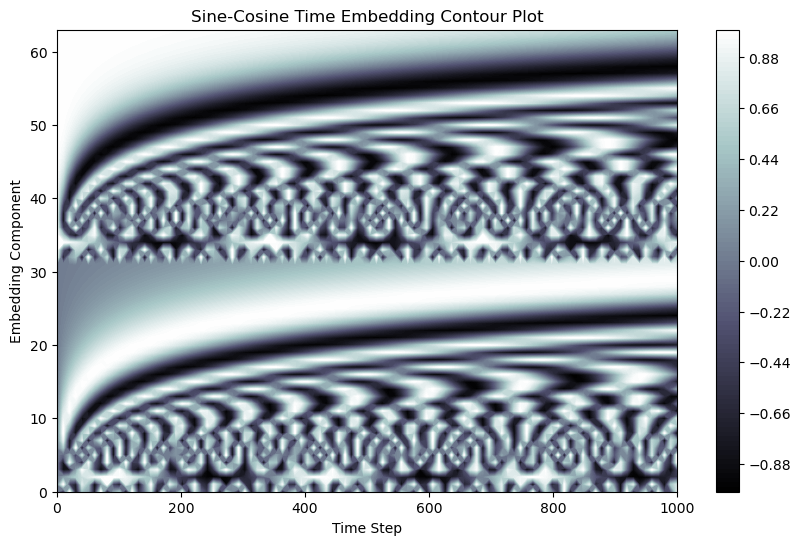

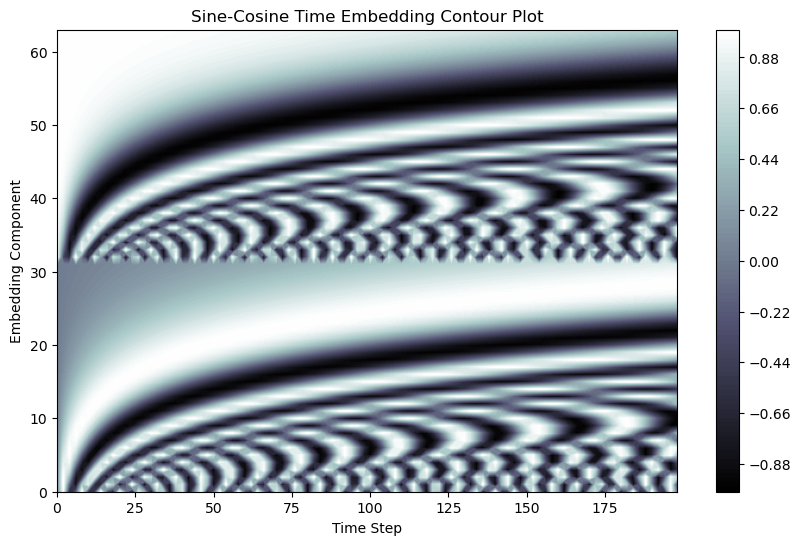

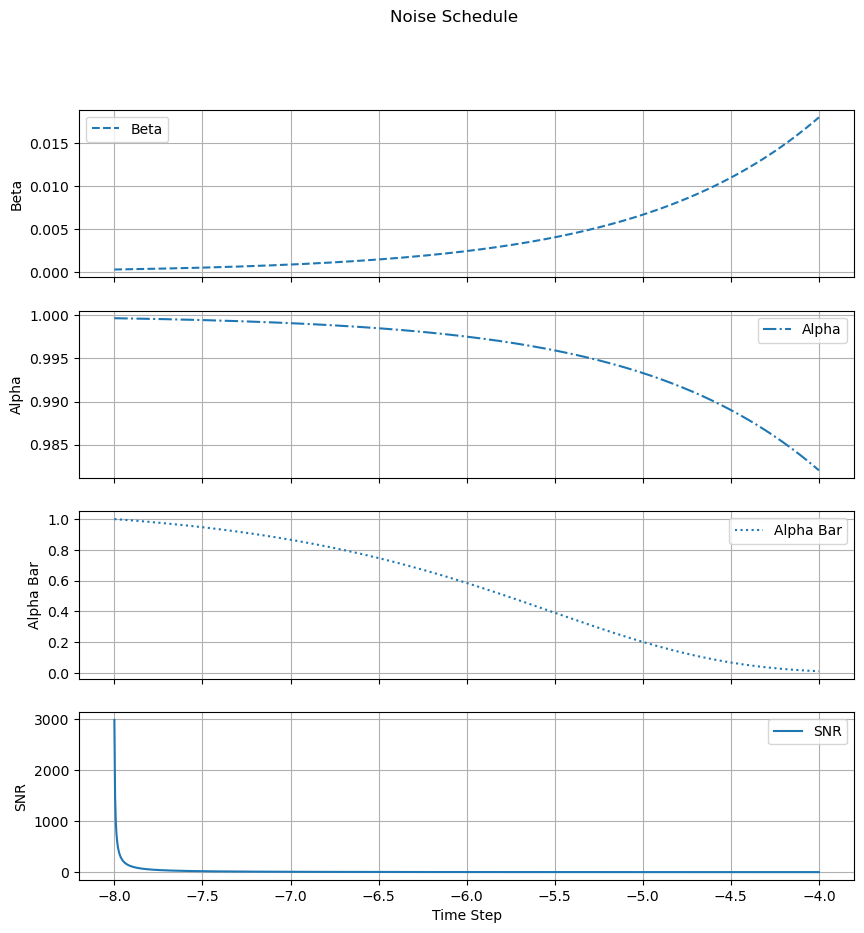

In [4]:
plot = t_diff_embedding.plot_embedding()
plot = s_phys_embedding.plot_embedding()
plot = noise_schedule.plot("Noise Schedule")

In [5]:
x_s_t = [position_data[199,:B],momentum_data[199,:B]]
x_0_0 = [position_data[0,:B],momentum_data[0,:B]]
v_0_0 = [torch.zeros_like(x_0_0[0],device=device)]
z_0_0 = [mass.unsqueeze(dim=0).expand(B,22), node_features['charge'].unsqueeze(dim=0).expand(B,22)]

out = DDPM(x_s_t, x_0_0, v_0_0, z_0_0, 200*torch.zeros(B,device=device,dtype=torch.int), 200*torch.ones(B,device=device,dtype=torch.int))

## test equivariance using commutator

In [6]:
num_iters = 20

median_total_mom_error = []
median_total_pos_error = []

mean_total_mom_error = []
mean_total_pos_error = []

eps_mom = 0.0
eps_pos = 0.0

with torch.no_grad():
    for i in range(num_iters):
        # Rotate position and momentum for x_s_t
        R = None
        RP, R, _ = random_rotation_3d(position_data[199,:B])  # rotate pos
        RM, _, _ = random_rotation_3d(momentum_data[199,:B], R)  # same R

        # rotate x_0_0
        R0P, _, _ = random_rotation_3d(position_data[0,:B], R)
        R0M, _, _ = random_rotation_3d(momentum_data[0,:B], R)

        # rotate v_0_0 (zeros)
        Rv0 = torch.zeros_like(R0P, device=device)

        # rotate scalar features
        z_mass = mass.unsqueeze(0).expand(B, 22)  # [B, N]
        z_charge = node_features['charge'].unsqueeze(0).expand(B, 22)  # [B, N]

        # build rotated inputs
        x_s_t_rot = [RP, RM]
        x_0_0_rot = [R0P, R0M]
        v_0_0_rot = [Rv0]
        z_0_0_rot = [z_mass, z_charge]

        # unrotated inputs
        x_s_t = [position_data[199,:B], momentum_data[199,:B]]
        x_0_0 = [position_data[0,:B], momentum_data[0,:B]]
        v_0_0 = [torch.zeros_like(position_data[0,:B], device=device)]
        z_0_0 = [z_mass, z_charge]

        t_diff = 200 * torch.zeros(B, device=position_data[0].device,dtype=torch.int)
        s_phys = 200 * torch.ones(B, device=position_data[0].device,dtype=torch.int)

        # evaluate model
        out_rot = DDPM(x_s_t_rot, x_0_0_rot, v_0_0_rot, z_0_0_rot, t_diff, s_phys)
        out_ref = DDPM(x_s_t, x_0_0, v_0_0, z_0_0, t_diff, s_phys)
        
        mom_rot = out_rot[0]  # [B, N, 3]
        pos_rot = out_rot[1]  # [B, N, 3]
        
        mom_ref = out_ref[0]
        pos_ref = out_ref[1]

        # rotate reference outputs
        Rmom_ref, _, _ = random_rotation_3d(mom_ref, R)
        Rpos_ref, _, _ = random_rotation_3d(pos_ref, R)


        # RMSD
        median_total_mom_error.append(torch.median((mom_rot - Rmom_ref)**2).sqrt().item())
        median_total_pos_error.append(torch.median((pos_rot - Rpos_ref)**2).sqrt().item())

        mean_total_mom_error.append(torch.mean((mom_rot - Rmom_ref)**2).sqrt().item())
        mean_total_pos_error.append(torch.mean((pos_rot - Rpos_ref)**2).sqrt().item())

        # relative error
        eps_mom += torch.linalg.vector_norm(mom_rot - Rmom_ref) / (
                   torch.linalg.vector_norm(mom_ref) + 1e-12)
        eps_pos += torch.linalg.vector_norm(pos_rot - Rpos_ref) / (
                   torch.linalg.vector_norm(pos_ref) + 1e-12)

    eps_mom /= num_iters
    eps_pos /= num_iters

    print(f"mean relative error in momentum over {num_iters} rotations: {eps_mom:.2e}")
    print(f"mean relative error in position over {num_iters} rotations: {eps_pos:.2e}\n")

    print(f"Median momentum RMSD averaged over {num_iters} rotations: {sum(median_total_mom_error) / num_iters:.6f}")
    print(f"Median position RMSD difference averaged over {num_iters} rotations: {sum(median_total_pos_error) / num_iters:.6f}\n")

    print(f"Mean momentum RMSD averaged over {num_iters} rotations: {sum(mean_total_mom_error) / num_iters:.6f}")
    print(f"Mean position RMSD difference averaged over {num_iters} rotations: {sum(mean_total_pos_error) / num_iters:.6f}\n")

mean relative error in momentum over 20 rotations: 2.36e-07
mean relative error in position over 20 rotations: 2.08e-07

Median momentum RMSD averaged over 20 rotations: 0.000000
Median position RMSD difference averaged over 20 rotations: 0.000000

Mean momentum RMSD averaged over 20 rotations: 0.000001
Mean position RMSD difference averaged over 20 rotations: 0.000001



## look at the forward trajectories

In [7]:
#Function to plot trajectory evolution for positions and momentum
@torch.no_grad()
def plot_trajectories(tensor, title):
    T, B, N, D = tensor.shape
    fig, ax = plt.subplots(figsize=(10, 6))
    for k in range(B):
        for j in range(N):
            for i in range(D):
                ax.plot(tensor[:, k, j, i].detach().cpu(), alpha=0.4, linewidth=0.8)
    ax.set_title(title)
    ax.set_xlabel("Diffusion Step t")
    plt.tight_layout()
    plt.show()

# Function to plot histogram vs standard normal
@torch.no_grad()
def plot_hist_vs_normal(data_tensor, title):
    data = data_tensor.flatten().detach().cpu()
    x = torch.linspace(-5, 5, 500)
    normal_pdf = torch.exp(-0.5 * x**2) / torch.sqrt(torch.tensor(2 * torch.pi))
    
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=100, density=True, alpha=0.6, label="model output over all batches, atoms, dims")
    plt.plot(x.numpy(), normal_pdf.numpy(), 'k--', linewidth=2, label="standard normal $\mathcal{N}(0,1)$")
    
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
# # Sample the trajectory
# forward = DDPM.sample_forward_trajectory(x_s_t)

# plot_trajectories(forward[0], "Position Trajectories")
# plot_trajectories(forward[1], "Momentum Trajectories")

# plot_hist_vs_normal(forward[0][-1], "Position Forward Output vs Standard Normal")
# plot_hist_vs_normal(forward[1][-1], "Momentum Forward Output vs Standard Normal")

# del forward

## look at the reverse trajectories

In [9]:
# # Sample the trajectory
# reverse = DDPM.sample_reverse_trajectory(x_0_0, v_0_0, z_0_0, s_phys)

# plot_trajectories(reverse[0], "Position Trajectories")
# plot_trajectories(reverse[1], "Momentum Trajectories")

# plot_hist_vs_normal(reverse[0][0], "Position Reverse Output vs Standard Normal")
# plot_hist_vs_normal(reverse[1][0], "Momentum Reverse Output vs Standard Normal")

In [10]:
# # Sample the trajectory
# reverse_marginal = DDPM.sample_reverse_marginal(x_0_0, v_0_0, z_0_0, t_diff_max, s_phys)

# plot_hist_vs_normal(reverse_marginal[0], "Position Forward Output vs Standard Normal")
# plot_hist_vs_normal(reverse_marginal[1], "Momentum Forward Output vs Standard Normal")

# del reverse_marginal

In [11]:
# # Sample the trajectory
# reverse_marginal = DDPM.sample_reverse_marginal(x_0_0, v_0_0, z_0_0, 0,s_phys)

# plot_hist_vs_normal(reverse_marginal[0], "Position Forward Output vs Standard Normal")
# plot_hist_vs_normal(reverse_marginal[1], "Momentum Forward Output vs Standard Normal")

# del reverse_marginal

In [12]:
class TrajectoryDataset():
    """
    Dataset class for trajectories with randomly selected initial conditions (IC).

    Args:
        trajectory (Tensor): Tensor of trajectories with shape [trajectory index, time, features].
        t_diff_max (int): Maximum diffusion time step.
        s_phys_max (int): Maximum physical time for sampling.
        device (str): Device to place tensors on (default: 'cpu').
        seed (int, optional): Seed for random number generation.
    """
    def __init__(self, trajectory, t_diff_max, s_phys_max, device,  seed=None):
        super().__init__()
        self.device = device
        self.s_phys_max = s_phys_max
        self.t_diff_max = t_diff_max
        self.trajectory = trajectory

        self.num_trajs = len(self.trajectory[0])
        self.data_dim = len(self.trajectory[0,0])

    def getitems(self, batch_size):
        traj_idxs = torch.randint(0, self.num_trajs, (batch_size,),device=self.device)
        
        N_vals = torch.rand(batch_size,device=self.device)  * np.log(self.s_phys_max)
        ic_idx = torch.randint(1, len(self.trajectory)- (self.s_phys_max), (batch_size,),device=self.device)
        
        s_phys = torch.floor(torch.exp(N_vals)).long()
        t_diff = torch.randint(0, self.t_diff_max, (batch_size,),device=self.device)
        x_0_0 = self.trajectory[ic_idx, traj_idxs]
        x_s_0 = self.trajectory[ic_idx + s_phys, traj_idxs]
        
        return {"x_0_0":x_0_0,
                "x_s_0":x_s_0,
                "t_diff":t_diff,
                "s_phys":s_phys}

    def getitem(self):
        return self.getitems(1)
         
dataset = TrajectoryDataset(torch.cat([position_data,momentum_data],dim=-1),t_diff_max,s_phys_max,device)

In [ ]:
wandb_step = 0
log_interval = 16
plot_interval = 2048
save_interval = 16*2048
grad_clipping = 0
name = f"BatchSize{B}"
checkpoint_path = "models/"

wandb.init(project="diffusion-training", name=name)

optimizer = optim.Adam(DDPM.parameters(),
                       lr = 1e-3,
                       betas = (0.9, 0.999),
                       eps = 1e-8, 
                       weight_decay = 0.0,
                       amsgrad = False)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99999)

epochs = 256
epoch_size = 2048*B 

for epoch in range(0, epochs):
    loader = tqdm(range(0, epoch_size, B), desc=f"Epoch {epoch+1}/{epochs}", leave=True, ncols=120, unit=' batch')
    for step in loader:
        batch = dataset.getitems(B)
        x_0_0 = [batch['x_0_0'][...,:3],batch['x_0_0'][...,3:]]         # Initial condition inferred vector features
        x_s_0 = [batch['x_s_0'][...,:3],batch['x_s_0'][...,3:]]         # Final condition inferred vector features
        v_0_0 = [torch.zeros_like(x_0_0[0],device=device)]              # Initial auxillary vector features
        z_0_0 = [mass.unsqueeze(dim=0).expand(B,22), 
                 node_features['charge'].unsqueeze(dim=0).expand(B,22)] # Initial auxillary scalar features
        t_diff = batch['t_diff']                                        # Diffusion time
        s_phys = batch['s_phys']                                        # Physical time
        
        optimizer.zero_grad()
        
        loss_list = DDPM.loss(x_s_t, x_0_0, v_0_0, z_0_0, t_diff, s_phys, flatten=True)
        pos_loss, mom_loss = loss_list
        loss = pos_loss + mom_loss
        loss.backward()

        if grad_clipping != 0:
            # Needs to be inspected. Does not work as intended.
            torch.nn.utils.clip_grad_norm_(DDPM.parameters(), max_norm=grad_clipping)

        optimizer.step()
        
        loader.set_postfix(
            batch=f"{int((step+1)/B)}/{int(epoch_size/B)}",
            loss=f"{loss.item():.6f}",
            pos=f"{pos_loss.item():.4e}",
            mom=f"{mom_loss.item():.4e}"
        )

        if wandb_step % log_interval == 0:
            wandb.log({
                "loss/total": loss.item(),
                "loss/position": pos_loss.item(),
                "loss/momentum": mom_loss.item(),
                "lr": scheduler.get_last_lr()[0],
            }, step=wandb_step)

            # Log gradients and parameters
            for name_, param in DDPM.named_parameters():
                if param.grad is not None:
                    wandb.log({f"gradients/{name_}": wandb.Histogram(param.grad.cpu().data.numpy())}, step=wandb_step)
                wandb.log({f"params/{name_}": wandb.Histogram(param.cpu().data.numpy())}, step=wandb_step)

        # if wandb_step % plot_interval == 0:
        #     with torch.no_grad():
        #         # Sample the trajectory
        #         reverse_marginal = DDPM.sample_reverse_marginal([x_0_0_[:64] for x_0_0_ in x_0_0], [v_0_0_[:64] for v_0_0_ in v_0_0], [z_0_0_[:64] for z_0_0_ in z_0_0], 0, s_phys[:64])
                
        #         plot_hist_vs_normal(reverse_marginal[0], "Position Reverse Output vs Standard Normal")
        #         plot_hist_vs_normal(reverse_marginal[1], "Momentum Reverse Output vs Standard Normal")
            
        #         del reverse_marginal

        if wandb_step % save_interval == 0:
            torch.save(DDPM, f"model_{wandb_step}.pth")

        wandb_step += 1
        scheduler.step()
       

    print(f"Epoch {epoch+1}: Loss = {loss.item():.6f}")

print("Training completed.")

wandb: Currently logged in as: winsaton (winsaton-univeristy-of-minnesota) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/256: 100%|█| 2048/2048 [03:56<00:00,  8.65 batch/s, batch=2047/2048, loss=1.270089, mom=7.0176e-01, pos=5.6833e-


Epoch 1: Loss = 1.270089


Epoch 2/256: 100%|█| 2048/2048 [03:56<00:00,  8.64 batch/s, batch=2047/2048, loss=0.938090, mom=5.9998e-01, pos=3.3811e-


Epoch 2: Loss = 0.938090


Epoch 3/256: 100%|█| 2048/2048 [03:59<00:00,  8.54 batch/s, batch=2047/2048, loss=0.845477, mom=5.8807e-01, pos=2.5741e-


Epoch 3: Loss = 0.845477


Epoch 4/256: 100%|█| 2048/2048 [04:02<00:00,  8.43 batch/s, batch=2047/2048, loss=0.836746, mom=5.5460e-01, pos=2.8214e-


Epoch 4: Loss = 0.836746


Epoch 5/256: 100%|█| 2048/2048 [04:04<00:00,  8.36 batch/s, batch=2047/2048, loss=0.694135, mom=4.3089e-01, pos=2.6324e-


Epoch 5: Loss = 0.694135


Epoch 6/256: 100%|█| 2048/2048 [04:08<00:00,  8.25 batch/s, batch=2047/2048, loss=0.452882, mom=2.9862e-01, pos=1.5426e-


Epoch 6: Loss = 0.452882


Epoch 7/256: 100%|█| 2048/2048 [04:08<00:00,  8.25 batch/s, batch=2047/2048, loss=0.467227, mom=2.9054e-01, pos=1.7668e-


Epoch 7: Loss = 0.467227


Epoch 8/256: 100%|█| 2048/2048 [04:10<00:00,  8.17 batch/s, batch=2047/2048, loss=0.328411, mom=2.0577e-01, pos=1.2264e-


Epoch 8: Loss = 0.328411


Epoch 9/256: 100%|█| 2048/2048 [04:12<00:00,  8.12 batch/s, batch=2047/2048, loss=0.443167, mom=2.6647e-01, pos=1.7670e-


Epoch 9: Loss = 0.443167


Epoch 10/256: 100%|█| 2048/2048 [04:10<00:00,  8.19 batch/s, batch=2047/2048, loss=0.401985, mom=2.4921e-01, pos=1.5277e


Epoch 10: Loss = 0.401985


Epoch 11/256: 100%|█| 2048/2048 [04:09<00:00,  8.19 batch/s, batch=2047/2048, loss=0.367328, mom=2.2538e-01, pos=1.4195e


Epoch 11: Loss = 0.367328


Epoch 12/256: 100%|█| 2048/2048 [04:11<00:00,  8.15 batch/s, batch=2047/2048, loss=0.322924, mom=2.0764e-01, pos=1.1528e


Epoch 12: Loss = 0.322924


Epoch 13/256: 100%|█| 2048/2048 [04:10<00:00,  8.17 batch/s, batch=2047/2048, loss=0.357766, mom=2.0599e-01, pos=1.5178e


Epoch 13: Loss = 0.357766


Epoch 14/256: 100%|█| 2048/2048 [04:12<00:00,  8.12 batch/s, batch=2047/2048, loss=0.349874, mom=1.9798e-01, pos=1.5189e


Epoch 14: Loss = 0.349874


Epoch 15/256: 100%|█| 2048/2048 [04:11<00:00,  8.14 batch/s, batch=2047/2048, loss=0.346487, mom=2.0457e-01, pos=1.4191e


Epoch 15: Loss = 0.346487


Epoch 16/256: 100%|█| 2048/2048 [04:13<00:00,  8.08 batch/s, batch=2047/2048, loss=0.318539, mom=1.8284e-01, pos=1.3570e


Epoch 16: Loss = 0.318539


Epoch 17/256: 100%|█| 2048/2048 [04:13<00:00,  8.08 batch/s, batch=2047/2048, loss=0.323943, mom=1.7783e-01, pos=1.4612e


Epoch 17: Loss = 0.323943


Epoch 18/256: 100%|█| 2048/2048 [04:14<00:00,  8.05 batch/s, batch=2047/2048, loss=0.460839, mom=2.7361e-01, pos=1.8723e


Epoch 18: Loss = 0.460839


Epoch 19/256: 100%|█| 2048/2048 [04:10<00:00,  8.17 batch/s, batch=2047/2048, loss=0.300557, mom=1.9495e-01, pos=1.0560e


Epoch 19: Loss = 0.300557


Epoch 20/256: 100%|█| 2048/2048 [04:06<00:00,  8.31 batch/s, batch=2047/2048, loss=0.278758, mom=1.8502e-01, pos=9.3738e


Epoch 20: Loss = 0.278758


Epoch 21/256: 100%|█| 2048/2048 [04:02<00:00,  8.44 batch/s, batch=2047/2048, loss=0.395004, mom=2.2289e-01, pos=1.7212e


Epoch 21: Loss = 0.395004


Epoch 22/256: 100%|█| 2048/2048 [03:42<00:00,  9.22 batch/s, batch=2047/2048, loss=0.280907, mom=1.7741e-01, pos=1.0350e


Epoch 22: Loss = 0.280907


Epoch 23/256: 100%|█| 2048/2048 [03:41<00:00,  9.24 batch/s, batch=2047/2048, loss=0.244927, mom=1.3941e-01, pos=1.0551e


Epoch 23: Loss = 0.244927


Epoch 24/256: 100%|█| 2048/2048 [03:40<00:00,  9.28 batch/s, batch=2047/2048, loss=0.263651, mom=1.6500e-01, pos=9.8656e


Epoch 24: Loss = 0.263651


Epoch 25/256: 100%|█| 2048/2048 [03:40<00:00,  9.29 batch/s, batch=2047/2048, loss=0.259079, mom=1.3853e-01, pos=1.2055e


Epoch 25: Loss = 0.259079


Epoch 26/256: 100%|█| 2048/2048 [03:33<00:00,  9.61 batch/s, batch=2047/2048, loss=0.361317, mom=2.0949e-01, pos=1.5183e


Epoch 26: Loss = 0.361317


Epoch 27/256: 100%|█| 2048/2048 [03:33<00:00,  9.61 batch/s, batch=2047/2048, loss=0.419285, mom=2.4837e-01, pos=1.7091e


Epoch 27: Loss = 0.419285


Epoch 28/256: 100%|█| 2048/2048 [03:37<00:00,  9.43 batch/s, batch=2047/2048, loss=0.225480, mom=1.2999e-01, pos=9.5487e


Epoch 28: Loss = 0.225480


Epoch 29/256: 100%|█| 2048/2048 [03:34<00:00,  9.55 batch/s, batch=2047/2048, loss=0.230647, mom=1.3699e-01, pos=9.3660e


Epoch 29: Loss = 0.230647


Epoch 30/256: 100%|█| 2048/2048 [03:34<00:00,  9.56 batch/s, batch=2047/2048, loss=0.238942, mom=1.3894e-01, pos=1.0000e


Epoch 30: Loss = 0.238942


Epoch 31/256: 100%|█| 2048/2048 [03:34<00:00,  9.53 batch/s, batch=2047/2048, loss=0.282406, mom=1.7058e-01, pos=1.1183e


Epoch 31: Loss = 0.282406


Epoch 32/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.241173, mom=1.5012e-01, pos=9.1058e


Epoch 32: Loss = 0.241173


Epoch 33/256: 100%|█| 2048/2048 [03:33<00:00,  9.58 batch/s, batch=2047/2048, loss=0.244187, mom=1.3134e-01, pos=1.1285e


Epoch 33: Loss = 0.244187


Epoch 34/256: 100%|█| 2048/2048 [03:34<00:00,  9.55 batch/s, batch=2047/2048, loss=0.336384, mom=1.9653e-01, pos=1.3986e


Epoch 34: Loss = 0.336384


Epoch 35/256: 100%|█| 2048/2048 [03:33<00:00,  9.58 batch/s, batch=2047/2048, loss=0.251946, mom=1.4945e-01, pos=1.0250e


Epoch 35: Loss = 0.251946


Epoch 36/256: 100%|█| 2048/2048 [03:34<00:00,  9.56 batch/s, batch=2047/2048, loss=0.237441, mom=1.4618e-01, pos=9.1261e


Epoch 36: Loss = 0.237441


Epoch 37/256: 100%|█| 2048/2048 [03:33<00:00,  9.57 batch/s, batch=2047/2048, loss=0.244259, mom=1.5520e-01, pos=8.9058e


Epoch 37: Loss = 0.244259


Epoch 38/256: 100%|█| 2048/2048 [03:33<00:00,  9.58 batch/s, batch=2047/2048, loss=0.216515, mom=1.2729e-01, pos=8.9227e


Epoch 38: Loss = 0.216515


Epoch 39/256: 100%|█| 2048/2048 [03:33<00:00,  9.59 batch/s, batch=2047/2048, loss=0.287334, mom=1.6421e-01, pos=1.2313e


Epoch 39: Loss = 0.287334


Epoch 40/256: 100%|█| 2048/2048 [03:33<00:00,  9.59 batch/s, batch=2047/2048, loss=0.215631, mom=1.2316e-01, pos=9.2475e


Epoch 40: Loss = 0.215631


Epoch 41/256: 100%|█| 2048/2048 [03:33<00:00,  9.58 batch/s, batch=2047/2048, loss=0.215637, mom=1.2816e-01, pos=8.7473e


Epoch 41: Loss = 0.215637


Epoch 42/256: 100%|█| 2048/2048 [03:34<00:00,  9.56 batch/s, batch=2047/2048, loss=0.243704, mom=1.4758e-01, pos=9.6122e


Epoch 42: Loss = 0.243704


Epoch 43/256: 100%|█| 2048/2048 [03:34<00:00,  9.55 batch/s, batch=2047/2048, loss=0.217774, mom=1.2149e-01, pos=9.6287e


Epoch 43: Loss = 0.217774


Epoch 44/256: 100%|█| 2048/2048 [03:34<00:00,  9.56 batch/s, batch=2047/2048, loss=0.202763, mom=1.1329e-01, pos=8.9471e


Epoch 44: Loss = 0.202763


Epoch 45/256: 100%|█| 2048/2048 [03:33<00:00,  9.58 batch/s, batch=2047/2048, loss=0.214279, mom=1.2748e-01, pos=8.6801e


Epoch 45: Loss = 0.214279


Epoch 46/256: 100%|█| 2048/2048 [03:33<00:00,  9.58 batch/s, batch=2047/2048, loss=0.171887, mom=1.0120e-01, pos=7.0686e


Epoch 46: Loss = 0.171887


Epoch 47/256: 100%|█| 2048/2048 [03:33<00:00,  9.58 batch/s, batch=2047/2048, loss=0.215043, mom=1.3997e-01, pos=7.5071e


Epoch 47: Loss = 0.215043


Epoch 48/256: 100%|█| 2048/2048 [03:34<00:00,  9.56 batch/s, batch=2047/2048, loss=0.270107, mom=1.6521e-01, pos=1.0490e


Epoch 48: Loss = 0.270107


Epoch 49/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.217608, mom=1.1888e-01, pos=9.8726e


Epoch 49: Loss = 0.217608


Epoch 50/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.195010, mom=1.1257e-01, pos=8.2438e


Epoch 50: Loss = 0.195010


Epoch 51/256: 100%|█| 2048/2048 [03:33<00:00,  9.61 batch/s, batch=2047/2048, loss=0.248606, mom=1.4243e-01, pos=1.0618e


Epoch 51: Loss = 0.248606


Epoch 52/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.193475, mom=1.1274e-01, pos=8.0733e


Epoch 52: Loss = 0.193475


Epoch 53/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.233980, mom=1.5091e-01, pos=8.3071e


Epoch 53: Loss = 0.233980


Epoch 54/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.213320, mom=1.1334e-01, pos=9.9978e


Epoch 54: Loss = 0.213320


Epoch 55/256: 100%|█| 2048/2048 [03:33<00:00,  9.61 batch/s, batch=2047/2048, loss=0.188605, mom=1.0841e-01, pos=8.0200e


Epoch 55: Loss = 0.188605


Epoch 56/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.196562, mom=1.1178e-01, pos=8.4783e


Epoch 56: Loss = 0.196562


Epoch 57/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.199582, mom=1.2027e-01, pos=7.9317e


Epoch 57: Loss = 0.199582


Epoch 58/256: 100%|█| 2048/2048 [03:33<00:00,  9.57 batch/s, batch=2047/2048, loss=0.151134, mom=7.7183e-02, pos=7.3952e


Epoch 58: Loss = 0.151134


Epoch 59/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.316149, mom=1.7024e-01, pos=1.4591e


Epoch 59: Loss = 0.316149


Epoch 60/256: 100%|█| 2048/2048 [03:32<00:00,  9.62 batch/s, batch=2047/2048, loss=0.212740, mom=1.2055e-01, pos=9.2191e


Epoch 60: Loss = 0.212740


Epoch 61/256: 100%|█| 2048/2048 [03:32<00:00,  9.63 batch/s, batch=2047/2048, loss=0.203376, mom=1.2473e-01, pos=7.8646e


Epoch 61: Loss = 0.203376


Epoch 62/256: 100%|█| 2048/2048 [03:32<00:00,  9.62 batch/s, batch=2047/2048, loss=0.173369, mom=8.7865e-02, pos=8.5504e


Epoch 62: Loss = 0.173369


Epoch 63/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.214027, mom=1.2616e-01, pos=8.7868e


Epoch 63: Loss = 0.214027


Epoch 64/256: 100%|█| 2048/2048 [03:33<00:00,  9.61 batch/s, batch=2047/2048, loss=0.195769, mom=1.1075e-01, pos=8.5017e


Epoch 64: Loss = 0.195769


Epoch 65/256: 100%|█| 2048/2048 [03:33<00:00,  9.59 batch/s, batch=2047/2048, loss=0.196326, mom=1.1527e-01, pos=8.1054e


Epoch 65: Loss = 0.196326


Epoch 66/256: 100%|█| 2048/2048 [03:33<00:00,  9.59 batch/s, batch=2047/2048, loss=0.189997, mom=1.1486e-01, pos=7.5139e


Epoch 66: Loss = 0.189997


Epoch 67/256: 100%|█| 2048/2048 [03:33<00:00,  9.58 batch/s, batch=2047/2048, loss=0.200608, mom=1.1750e-01, pos=8.3106e


Epoch 67: Loss = 0.200608


Epoch 68/256: 100%|█| 2048/2048 [03:34<00:00,  9.57 batch/s, batch=2047/2048, loss=0.197426, mom=1.1179e-01, pos=8.5635e


Epoch 68: Loss = 0.197426


Epoch 69/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.174698, mom=1.0452e-01, pos=7.0180e


Epoch 69: Loss = 0.174698


Epoch 70/256: 100%|█| 2048/2048 [03:33<00:00,  9.57 batch/s, batch=2047/2048, loss=0.208479, mom=1.1790e-01, pos=9.0576e


Epoch 70: Loss = 0.208479


Epoch 71/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.181172, mom=1.0481e-01, pos=7.6357e


Epoch 71: Loss = 0.181172


Epoch 72/256: 100%|█| 2048/2048 [03:34<00:00,  9.57 batch/s, batch=2047/2048, loss=0.253378, mom=1.3616e-01, pos=1.1722e


Epoch 72: Loss = 0.253378


Epoch 73/256: 100%|█| 2048/2048 [03:33<00:00,  9.58 batch/s, batch=2047/2048, loss=0.216254, mom=1.1780e-01, pos=9.8452e


Epoch 73: Loss = 0.216254


Epoch 74/256: 100%|█| 2048/2048 [03:34<00:00,  9.56 batch/s, batch=2047/2048, loss=0.161599, mom=9.0638e-02, pos=7.0961e


Epoch 74: Loss = 0.161599


Epoch 75/256: 100%|█| 2048/2048 [03:33<00:00,  9.59 batch/s, batch=2047/2048, loss=0.214173, mom=1.2158e-01, pos=9.2593e


Epoch 75: Loss = 0.214173


Epoch 76/256: 100%|█| 2048/2048 [03:33<00:00,  9.59 batch/s, batch=2047/2048, loss=0.190999, mom=1.1550e-01, pos=7.5497e


Epoch 76: Loss = 0.190999


Epoch 77/256: 100%|█| 2048/2048 [03:33<00:00,  9.61 batch/s, batch=2047/2048, loss=0.214495, mom=1.2100e-01, pos=9.3497e


Epoch 77: Loss = 0.214495


Epoch 78/256: 100%|█| 2048/2048 [03:33<00:00,  9.61 batch/s, batch=2047/2048, loss=0.227729, mom=1.3710e-01, pos=9.0631e


Epoch 78: Loss = 0.227729


Epoch 79/256: 100%|█| 2048/2048 [03:32<00:00,  9.62 batch/s, batch=2047/2048, loss=0.178959, mom=9.6886e-02, pos=8.2073e


Epoch 79: Loss = 0.178959


Epoch 80/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.182647, mom=1.1269e-01, pos=6.9960e


Epoch 80: Loss = 0.182647


Epoch 81/256: 100%|█| 2048/2048 [03:33<00:00,  9.61 batch/s, batch=2047/2048, loss=0.200984, mom=1.1915e-01, pos=8.1834e


Epoch 81: Loss = 0.200984


Epoch 82/256: 100%|█| 2048/2048 [03:34<00:00,  9.56 batch/s, batch=2047/2048, loss=0.196306, mom=1.2018e-01, pos=7.6127e


Epoch 82: Loss = 0.196306


Epoch 83/256: 100%|█| 2048/2048 [03:32<00:00,  9.62 batch/s, batch=2047/2048, loss=0.212891, mom=1.1786e-01, pos=9.5030e


Epoch 83: Loss = 0.212891


Epoch 84/256: 100%|█| 2048/2048 [03:32<00:00,  9.62 batch/s, batch=2047/2048, loss=0.191575, mom=1.0735e-01, pos=8.4227e


Epoch 84: Loss = 0.191575


Epoch 85/256: 100%|█| 2048/2048 [03:32<00:00,  9.63 batch/s, batch=2047/2048, loss=0.181496, mom=1.1257e-01, pos=6.8925e


Epoch 85: Loss = 0.181496


Epoch 86/256: 100%|█| 2048/2048 [03:33<00:00,  9.59 batch/s, batch=2047/2048, loss=0.173803, mom=1.0128e-01, pos=7.2524e


Epoch 86: Loss = 0.173803


Epoch 87/256: 100%|█| 2048/2048 [03:32<00:00,  9.62 batch/s, batch=2047/2048, loss=0.205888, mom=1.1899e-01, pos=8.6896e


Epoch 87: Loss = 0.205888


Epoch 88/256: 100%|█| 2048/2048 [03:32<00:00,  9.66 batch/s, batch=2047/2048, loss=0.221674, mom=1.2855e-01, pos=9.3119e


Epoch 88: Loss = 0.221674


Epoch 89/256: 100%|█| 2048/2048 [03:33<00:00,  9.57 batch/s, batch=2047/2048, loss=0.178220, mom=1.0238e-01, pos=7.5841e


Epoch 89: Loss = 0.178220


Epoch 90/256: 100%|█| 2048/2048 [03:33<00:00,  9.59 batch/s, batch=2047/2048, loss=0.157157, mom=8.8495e-02, pos=6.8662e


Epoch 90: Loss = 0.157157


Epoch 91/256: 100%|█| 2048/2048 [03:33<00:00,  9.61 batch/s, batch=2047/2048, loss=0.150469, mom=7.9388e-02, pos=7.1081e


Epoch 91: Loss = 0.150469


Epoch 92/256: 100%|█| 2048/2048 [03:33<00:00,  9.60 batch/s, batch=2047/2048, loss=0.146507, mom=7.8483e-02, pos=6.8024e


Epoch 92: Loss = 0.146507


Epoch 93/256: 100%|█| 2048/2048 [03:33<00:00,  9.58 batch/s, batch=2047/2048, loss=0.164190, mom=9.1606e-02, pos=7.2584e


Epoch 93: Loss = 0.164190


Epoch 94/256: 100%|█| 2048/2048 [03:33<00:00,  9.58 batch/s, batch=2047/2048, loss=0.177909, mom=9.5026e-02, pos=8.2882e


Epoch 94: Loss = 0.177909


Epoch 95/256: 100%|█| 2048/2048 [03:34<00:00,  9.56 batch/s, batch=2047/2048, loss=0.211551, mom=1.2792e-01, pos=8.3630e


Epoch 95: Loss = 0.211551


Epoch 96/256: 100%|█| 2048/2048 [03:33<00:00,  9.57 batch/s, batch=2047/2048, loss=0.152732, mom=8.6304e-02, pos=6.6429e


Epoch 96: Loss = 0.152732


Epoch 97/256: 100%|█| 2048/2048 [03:34<00:00,  9.56 batch/s, batch=2047/2048, loss=0.182523, mom=1.0061e-01, pos=8.1914e


Epoch 97: Loss = 0.182523


Epoch 98/256: 100%|█| 2048/2048 [03:34<00:00,  9.55 batch/s, batch=2047/2048, loss=0.187452, mom=1.1949e-01, pos=6.7962e


Epoch 98: Loss = 0.187452


Epoch 99/256:   6%| | 113/2048 [00:11<03:34,  9.03 batch/s, batch=113/2048, loss=0.188092, mom=9.8536e-02, pos=8.9556e-0

In [10]:
top, node_features, mass, energy_dict = build_top_and_features("datasets/AlanaineDipeptideVacuum/alanine-dipeptide.prmtop")
atomic_numbers = [a.atomic_number for a in pmd.load_file("datasets/AlanaineDipeptideVacuum/alanine-dipeptide.prmtop").atoms]
save_pdb_with_bonds(dataset.getitem()['x_0_0'][0][:,:3],atomic_numbers,top)

In [27]:
revsamples = DDPM.sample_reverse_marginal([x_0_0_.expand(64,22,3) for x_0_0_ in x_0_0], 
                                          [v_0_0_[:64] for v_0_0_ in v_0_0], 
                                          [z_0_0_[:64] for z_0_0_ in z_0_0], 0, 
                                          198*torch.ones(64,device=device))